# Museum Detection (COMP 6721)

Done by:

1. Bhavya Patel (40304250)
2. Yashesh Sorathia (40267022)
3. Chama Amri Toudrhi (40180557)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Extracting the dataset from the zip file
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/museum_train.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [3]:
# Import necessary libraries
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### Dataset Loading and Preprocessing
- **Dataset Paths**:
  - Indoor images: `museum_train/indoor/`
  - Outdoor images: `museum_train/outdoor/`
- **Preprocessing Steps**:
  - Resize images to `64x64` pixels.
  - Convert images to grayscale.
  - Flatten images into 1D arrays.
  - Normalize pixel values to the range `[0, 1]`.
- **Labels**:
  - Indoor: `0`
  - Outdoor: `1`

In [4]:
# Define paths for indoor and outdoor training images
indoor_train_path = 'museum_train/indoor/'
outdoor_train_path = 'museum_train/outdoor/'

In [5]:
# Function to load images from a folder and preprocess them
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
         # Open and resize the image
        img = Image.open(os.path.join(folder, filename))
        img = img.resize((64, 64)) # Resize images to a common size
        img = img.convert('L') # Convert to grayscale
        img = np.array(img).flatten() # Flatten the image to 1D array
        img = img/255 # Normalize pixel values to [0, 1]
        images.append(img)
        labels.append(label)
    return images, labels

In [6]:
# Load indoor and outdoor images
indoor_train_images, indoor_train_labels = load_images_from_folder(indoor_train_path, label=0)
outdoor_train_images, outdoor_train_labels = load_images_from_folder(outdoor_train_path, label=1)

In [7]:
# Combine indoor and outdoor images into a single dataset
X = np.array(indoor_train_images + outdoor_train_images)
y = np.array(indoor_train_labels + outdoor_train_labels)

### Semi-Supervised Learning (Pseudo-Labeling)
- **Unlabeled Data**: 50% of the dataset is treated as unlabeled (`y_unlabeled = -1`).
- **Self-Training Loop**:
  - Predict pseudo-labels for unlabeled data.
  - Select high-confidence predictions (confidence threshold = `0.95`).
  - Add pseudo-labeled data to the training set.
  - Retrain the model iteratively (up to `10` iterations).

In [8]:
# Split the dataset into training and unlabeled sets (50% unlabeled)
X_train, X_unlabeled, y_train, y_unlabeled = train_test_split(X, y, test_size=0.5, random_state=42)

In [30]:
X_train_dump, X_test_dump, y_train_dump, y_test_dump = train_test_split(X, y, test_size=0.5, random_state=42)

In [10]:
# Remove label from unlabeled data
y_unlabeled[:] = -1

# Model Training and Evaluation
- **Model 1**: Decision Tree with default hyperparameters.
  - Criterion: `gini`
  - Max Depth: `10`
  - Min Samples Leaf: `20`
  - Max Features: `sqrt`
- **Model 2**: Decision Tree with increased depth and adjusted hyperparameters.
  - Criterion: `gini`
  - Max Depth: `15`
  - Min Samples Leaf: `30`
  - Max Features: `sqrt`
- **Model 3**: Decision Tree with entropy criterion and adjusted hyperparameters.
  - Criterion: `entropy`
  - Max Depth: `9`
  - Min Samples Leaf: `20`
  - Max Features: `log2`
- **Evaluation Metrics**:
  - Accuracy, Precision, Recall, F1-Score, and Confusion Matrix.

### Training Model 1 : Decision Tree with default hyperparameters.

In [11]:
# Train Model 1: Decision Tree with default hyperparameters
model_1 = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    splitter='best',
    min_samples_split=2,
    min_samples_leaf=20,
    class_weight='balanced',
    max_features='sqrt',
    random_state=42)
model_1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', min_samples_leaf=20,
                       random_state=42)

In [12]:
# Self-training loop (pseudo-labeling)
max_iterations = 10  # Maximum iterations for self-training
confidence_threshold = 0.95  # Minimum confidence for pseudo-labeling

In [13]:
for i in range(max_iterations):
    # Predict pseudo-labels for unlabeled data
    pseudo_labels = model_1.predict(X_unlabeled)
    pseudo_probs = model_1.predict_proba(X_unlabeled).max(axis=1)  # Get confidence scores

    # Select samples with high confidence
    high_confidence_mask = pseudo_probs >= confidence_threshold
    newly_labeled_X = X_unlabeled[high_confidence_mask]
    newly_labeled_y = pseudo_labels[high_confidence_mask]

    # If no new high-confidence labels, stop training
    if len(newly_labeled_X) == 0:
        break

    # Add pseudo-labeled data to training set
    X_train = np.vstack([X_train, newly_labeled_X])
    y_train = np.hstack([y_train, newly_labeled_y])

    # Remove pseudo-labeled samples from unlabeled set
    X_unlabeled = X_unlabeled[~high_confidence_mask]
    y_unlabeled = y_unlabeled[~high_confidence_mask]

    # Retrain Decision Tree with the expanded dataset
    model_1.fit(X_train, y_train)

### Evaluation Metrics for Model 1

Accuracy: 70.28%
Precision: 68.40%
Recall: 72.50%
F1 Score: 70.39%


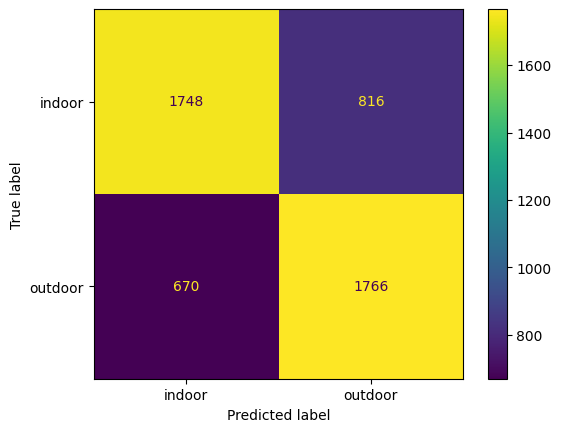

In [14]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay

# Evaluate Model 1
y_pred = model_1.predict(X_test_dump)

accuracy = accuracy_score(y_test_dump, y_pred)
precision = precision_score(y_test_dump,y_pred)
recall = recall_score(y_test_dump,y_pred)
f1score = f1_score(y_test_dump,y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1score * 100:.2f}%')
ConfusionMatrixDisplay.from_predictions(y_test_dump,y_pred,display_labels=['indoor','outdoor'])

### Testing on a Single Image
- A single image is loaded, preprocessed, and passed through the trained model for prediction.
- The image is resized, converted to grayscale, flattened, and normalized before prediction.

In [15]:
def load_single_images(image):
    img = Image.open(image)
    img = img.resize((64, 64))
    img = img.convert('L')
    img = np.array(img).flatten()
    img = img/255
    return img

In [16]:
my_img = load_single_images('/content/test_image_1.jpg')

In [17]:
# Test Model 1 on a single image
if(model_1.predict(my_img.reshape(1,-1)) == 0):
  print("Indoor Museum")
else:
  print("Outdoor Museum")

Indoor Museum


### Training Model 2 : Decision Tree with increased depth and adjusted hyperparameters.

In [18]:
# Train Model 2: Decision Tree with increased depth and adjusted hyperparameters
model_2 = DecisionTreeClassifier(
    criterion='gini',
    max_depth=15,
    splitter='best',
    min_samples_split=2,
    min_samples_leaf=30,
    class_weight='balanced',
    max_features='sqrt',
    random_state=42)

model_2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=15,
                       max_features='sqrt', min_samples_leaf=30,
                       random_state=42)

In [19]:
# Self-training loop (pseudo-labeling)
max_iterations = 10  # Maximum iterations for self-training
confidence_threshold = 0.95  # Minimum confidence for pseudo-labeling

In [20]:
for i in range(max_iterations):
    # Predict pseudo-labels for unlabeled data
    pseudo_labels = model_2.predict(X_unlabeled)
    pseudo_probs = model_2.predict_proba(X_unlabeled).max(axis=1)  # Get confidence scores

    # Select samples with high confidence
    high_confidence_mask = pseudo_probs >= confidence_threshold
    newly_labeled_X = X_unlabeled[high_confidence_mask]
    newly_labeled_y = pseudo_labels[high_confidence_mask]

    # If no new high-confidence labels, stop training
    if len(newly_labeled_X) == 0:
        break

    # Add pseudo-labeled data to training set
    X_train = np.vstack([X_train, newly_labeled_X])
    y_train = np.hstack([y_train, newly_labeled_y])

    # Remove pseudo-labeled samples from unlabeled set
    X_unlabeled = X_unlabeled[~high_confidence_mask]
    y_unlabeled = y_unlabeled[~high_confidence_mask]

    # Retrain Decision Tree with the expanded dataset
    model_2.fit(X_train, y_train)

### Evaluation Metrics for Model 2

Accuracy: 70.30%
Precision: 69.62%
Recall: 69.25%
F1 Score: 69.44%


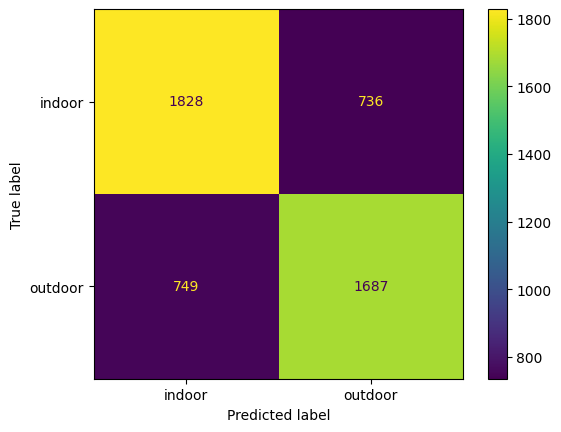

In [21]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay

# Evaluate Model 2
y_pred = model_2.predict(X_test_dump)

accuracy = accuracy_score(y_test_dump, y_pred)
precision = precision_score(y_test_dump,y_pred)
recall = recall_score(y_test_dump,y_pred)
f1score = f1_score(y_test_dump,y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1score * 100:.2f}%')
ConfusionMatrixDisplay.from_predictions(y_test_dump,y_pred,display_labels=['indoor','outdoor'])

### Testing model on test image

In [22]:
# Test Model 2 on a single image
if(model_2.predict(my_img.reshape(1,-1)) == 0):
  print("Indoor Museum")
else:
  print("Outdoor Museum")

Indoor Museum


### Training Model 3: Decision Tree with entropy criterion and adjusted hyperparameters.

In [23]:
# Train Model 3: Decision Tree with entropy criterion and adjusted hyperparameters
model_3 = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=9,
    splitter='best',
    min_samples_split=10,
    min_samples_leaf=20,
    class_weight='balanced',
    max_features='log2',
    random_state=42)


model_3.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, max_features='log2', min_samples_leaf=20,
                       min_samples_split=10, random_state=42)

In [24]:
# Self-training loop (pseudo-labeling)
max_iterations = 10  # Maximum iterations for self-training
confidence_threshold = 0.95  # Minimum confidence for pseudo-labeling

In [25]:
for i in range(max_iterations):
    # Predict pseudo-labels for unlabeled data
    pseudo_labels = model_3.predict(X_unlabeled)
    pseudo_probs = model_3.predict_proba(X_unlabeled).max(axis=1)  # Get confidence scores

    # Select samples with high confidence
    high_confidence_mask = pseudo_probs >= confidence_threshold
    newly_labeled_X = X_unlabeled[high_confidence_mask]
    newly_labeled_y = pseudo_labels[high_confidence_mask]

    # If no new high-confidence labels, stop training
    if len(newly_labeled_X) == 0:
        break

    # Add pseudo-labeled data to training set
    X_train = np.vstack([X_train, newly_labeled_X])
    y_train = np.hstack([y_train, newly_labeled_y])

    # Remove pseudo-labeled samples from unlabeled set
    X_unlabeled = X_unlabeled[~high_confidence_mask]
    y_unlabeled = y_unlabeled[~high_confidence_mask]

    # Retrain Decision Tree with the expanded dataset
    model_3.fit(X_train, y_train)

### Evaluation Metrics for Model 3

Accuracy: 69.22%
Precision: 67.55%
Recall: 70.85%
F1 Score: 69.16%


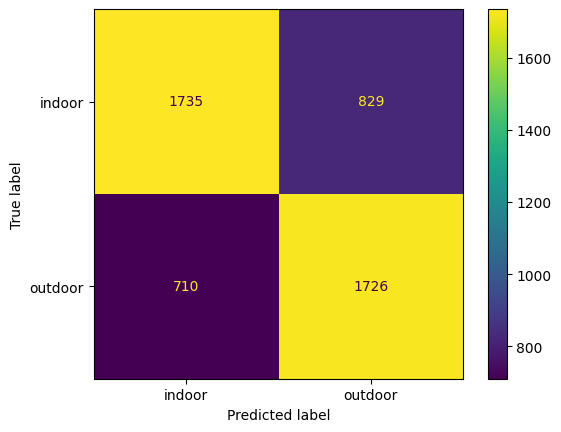

In [26]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay

# Evaluate Model 3
y_pred = model_3.predict(X_test_dump)

accuracy = accuracy_score(y_test_dump, y_pred)
precision = precision_score(y_test_dump,y_pred)
recall = recall_score(y_test_dump,y_pred)
f1score = f1_score(y_test_dump,y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1score * 100:.2f}%')
ConfusionMatrixDisplay.from_predictions(y_test_dump,y_pred,display_labels=['indoor','outdoor'])

### Testing model on test image

In [27]:
# Test Model 3 on a single image
if(model_3.predict(my_img.reshape(1,-1)) == 0):
  print("Indoor Museum")
else:
  print("Outdoor Museum")

Indoor Museum


### Saving all models

In [28]:
import pickle

def save_model_pickle(model, path="model.pkl"):
    with open(path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {path}")


save_model_pickle(model_1, "museum_detection_dt_ss_model_1.pkl")
save_model_pickle(model_2, "museum_detection_dt_ss_model_2.pkl")
save_model_pickle(model_3, "museum_detection_dt_ss_model_3.pkl")

Model saved to museum_detection_dt_ss_model_1.pkl
Model saved to museum_detection_dt_ss_model_2.pkl
Model saved to museum_detection_dt_ss_model_3.pkl


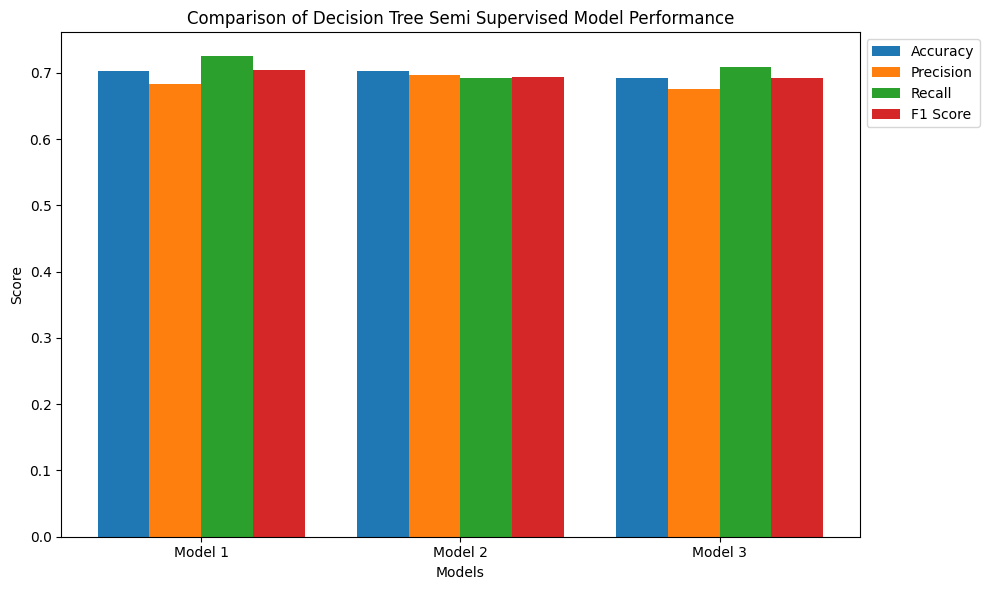

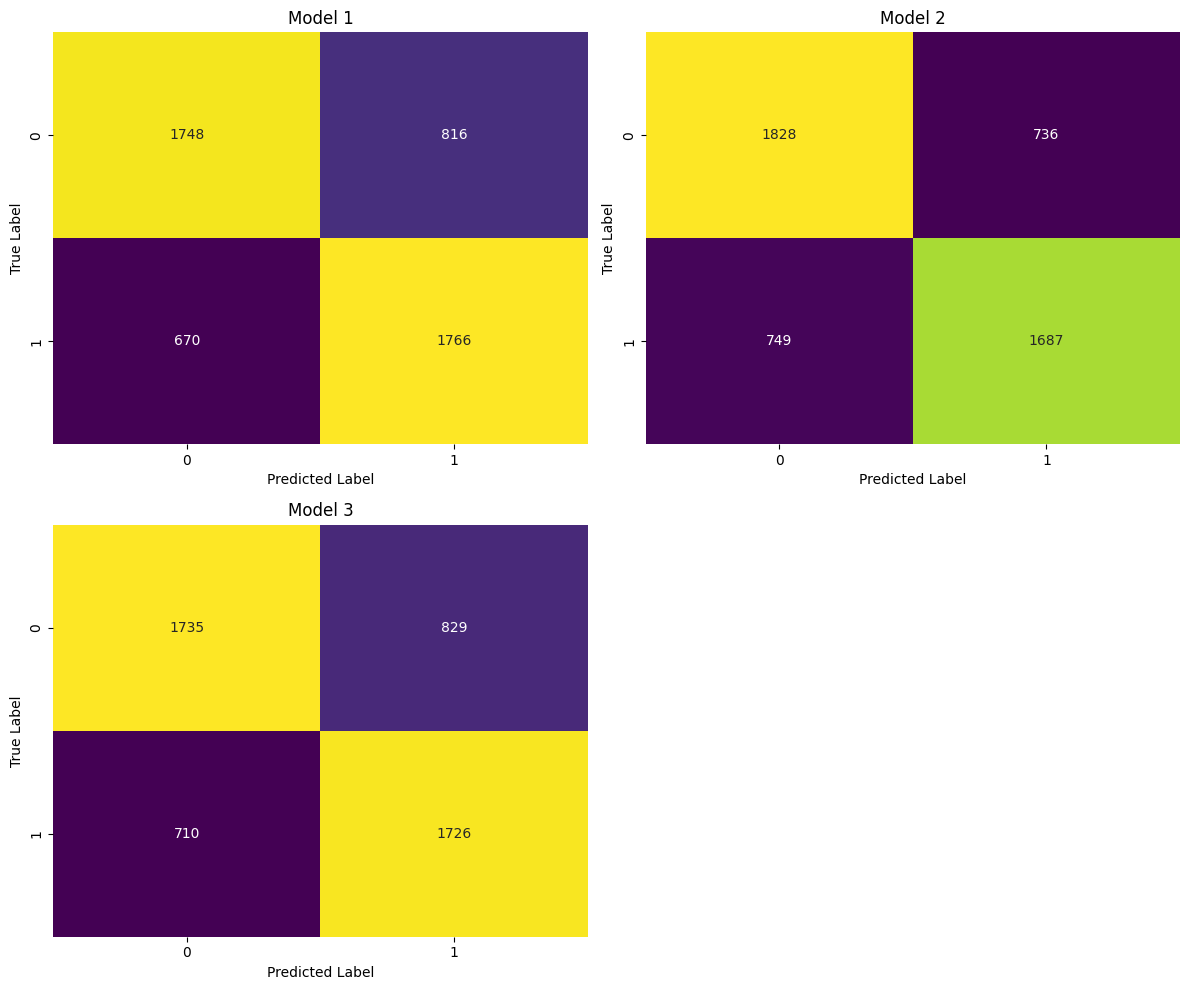

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

# Assuming you have already trained three models and have their predictions
y_pred_1 = model_1.predict(X_test_dump)
y_pred_2 = model_2.predict(X_test_dump)
y_pred_3 = model_3.predict(X_test_dump)

# Compute evaluation metrics for each model
models = ["Model 1", "Model 2", "Model 3"]
accuracy = [accuracy_score(y_test_dump, y_pred_1), accuracy_score(y_test_dump, y_pred_2), accuracy_score(y_test_dump, y_pred_3)]
precision = [precision_score(y_test_dump, y_pred_1), precision_score(y_test_dump, y_pred_2), precision_score(y_test_dump, y_pred_3)]
recall = [recall_score(y_test_dump, y_pred_1), recall_score(y_test_dump, y_pred_2), recall_score(y_test_dump, y_pred_3)]
f1_score_values = [f1_score(y_test_dump, y_pred_1), f1_score(y_test_dump, y_pred_2), f1_score(y_test_dump, y_pred_3)]

# Create a grouped bar chart
x = np.arange(len(models))  # Label locations
width = 0.2  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 1.5*width, accuracy, width, label="Accuracy")
ax.bar(x - 0.5*width, precision, width, label="Precision")
ax.bar(x + 0.5*width, recall, width, label="Recall")
ax.bar(x + 1.5*width, f1_score_values, width, label="F1 Score")

ax.set_xlabel("Models")
ax.set_ylabel("Score")
ax.set_title("Comparison of Decision Tree Semi Supervised Model Performance")
ax.set_xticks(x)
ax.set_xticklabels(models)

# Move legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()  # Ensures everything fits well
plt.show()

print()

# Generate and plot Confusion Matrices with 2-row layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns for layout
axes = axes.flatten()  # Flatten for easy iteration

# Confusion matrices for each model
y_preds = [y_pred_1, y_pred_2, y_pred_3]

for i, (ax, model, y_pred) in enumerate(zip(axes, models, y_preds)):
    cm = confusion_matrix(y_test_dump, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", ax=ax, cbar=False)
    ax.set_title(model)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

# Remove the last subplot (extra blank space if only 3 models)
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()